In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv("/content/SBMMerge.csv",encoding='latin1')
df.head()

,Year,Month,ShopName,Item,Quantity,Total,Wholesale,Profit
0,2022,October,Gampaha,4rever 5 min clean -up,1,Rs. 570.00,Rs. 456.75,Rs. 113.25
1,2022,October,Gampaha,4rever black head remove,10,"Rs. 1,360.00","Rs. 1,087.50",Rs. 272.50
2,2022,October,Gampaha,4rever body wash,1,Rs. 440.00,Rs. 471.25,-Rs. 31.25
3,2022,October,Gampaha,4rever day cream,1,Rs. 630.00,Rs. 525.00,Rs. 105.00
4,2022,October,Gampaha,4rever eye cream,1,Rs. 620.00,Rs. 493.00,Rs. 127.00


In [3]:

# Create Date column with first day of each month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# Optional: Add random days within each month (uncomment to use)
# df['Date'] = df['Date'] + pd.to_timedelta(np.random.randint(0, 28, len(df)), unit='D')

df.tail()

,Year,Month,ShopName,Item,Quantity,Total,Wholesale,Profit,Date
33962,2024,October,Gampaha,xhc coconut conditioner,1,"Rs. 1,800.00","Rs. 1,350.00",Rs. 450.00,2024-10-01
33963,2024,October,Gampaha,xhc coconut shampo,1,"Rs. 1,500.00","Rs. 1,100.00",Rs. 400.00,2024-10-01
33964,2024,October,Gampaha,YC face wash,3,"Rs. 2,850.00","Rs. 1,440.00","Rs. 1,410.00",2024-10-01
33965,2024,October,Gampaha,yc gold face wash,1,Rs. 950.00,Rs. 480.00,Rs. 470.00,2024-10-01
33966,2024,October,Gampaha,yellow comb,3,Rs. 240.00,Rs. 120.00,Rs. 120.00,2024-10-01


In [4]:
# Drop unnecessary columns
df = df.drop(['Year', 'Month'], axis=1)
df.head()


,ShopName,Item,Quantity,Total,Wholesale,Profit,Date
0,Gampaha,4rever 5 min clean -up,1,Rs. 570.00,Rs. 456.75,Rs. 113.25,2022-10-01
1,Gampaha,4rever black head remove,10,"Rs. 1,360.00","Rs. 1,087.50",Rs. 272.50,2022-10-01
2,Gampaha,4rever body wash,1,Rs. 440.00,Rs. 471.25,-Rs. 31.25,2022-10-01
3,Gampaha,4rever day cream,1,Rs. 630.00,Rs. 525.00,Rs. 105.00,2022-10-01
4,Gampaha,4rever eye cream,1,Rs. 620.00,Rs. 493.00,Rs. 127.00,2022-10-01


In [5]:
df.isnull().sum()

,0
ShopName,0
Item,0
Quantity,0
Total,0
Wholesale,0
Profit,0
Date,0


In [6]:
columns_to_clean = ['Total', 'Wholesale', 'Profit']  # Replace with your column names

for col in columns_to_clean:
   df[col] = (
       df[col]
       .astype(str)  # Ensure the column is treated as strings for replacement
       .str.replace('Rs.', '', regex=False)  # Remove 'Rs.' (case-sensitive)
       .str.replace(',', '', regex=False)  # Remove commas
       .str.replace('\xa0', '', regex=False)  # Remove non-breaking spaces
       .str.replace('- ', '-', regex=False)  # Fix spaces around negative sign
       .str.strip()  # Remove any leading or trailing whitespace
       .replace('-', '0')  # Replace '-' with '0' to handle missing or negative-like values
       .replace('', '0')  # Replace empty strings with '0'
       .astype(float)  # Convert the cleaned values to float
)

In [7]:
# Aggregate data to predict quantity per shop and item per month
df['Month'] = df['Date'].dt.to_period('M')
monthly_data = df.groupby(['ShopName', 'Item', 'Month']).agg({
    'Quantity': 'sum',
    'Total': 'sum',
    'Wholesale': 'mean',
    'Profit': 'sum'
}).reset_index()


In [8]:
# Convert 'month' back to datetime for modeling
monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()

In [9]:
# Step 3: Feature engineering
# Generate lag features for quantity
def create_lag_features(df, lag_features, target_col):
    for lag in lag_features:
        df[f'quantity_lag_{lag}'] = df.groupby(['ShopName', 'Item'])[target_col].shift(lag)
    return df

lag_features = [1, 2, 3]
monthly_data = create_lag_features(monthly_data, lag_features, 'Quantity')

In [10]:
# Drop rows with NaN values (due to lagging)
monthly_data = monthly_data.dropna()

In [13]:
# Step 4: Prepare data for modeling
# Define features and target
target = 'Quantity'
features = ['quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'Total', 'Wholesale', 'Profit']


In [14]:
df.head()

,ShopName,Item,Quantity,Total,Wholesale,Profit,Date,Month
0,Gampaha,4rever 5 min clean -up,1,570.0,456.75,113.25,2022-10-01,2022-10
1,Gampaha,4rever black head remove,10,1360.0,1087.50,272.50,2022-10-01,2022-10
2,Gampaha,4rever body wash,1,440.0,471.25,-31.25,2022-10-01,2022-10
3,Gampaha,4rever day cream,1,630.0,525.00,105.00,2022-10-01,2022-10
4,Gampaha,4rever eye cream,1,620.0,493.00,127.00,2022-10-01,2022-10


In [15]:
X = monthly_data[features]
y = monthly_data[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Step 5: Build the Machine Learning Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [17]:
# Step 6: Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=42))])

In [18]:
# Step 7: Evaluate the model
predictions = pipeline.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3018.92201375102


In [19]:
# Step 8: Predict for the next few months
# Generate future months for prediction
import datetime
future_months = 3  # Change this to predict more months
last_month = monthly_data['Month'].max()
future_dates = [last_month + datetime.timedelta(days=30 * i) for i in range(1, future_months + 1)]


In [20]:
# Prepare prediction input for each future month
future_predictions = []
current_data = monthly_data.copy()
for future_date in future_dates:
    prediction_input = current_data[current_data['Month'] == current_data['Month'].max()][features]
    predicted_quantities = pipeline.predict(prediction_input)
    prediction_result = current_data[current_data['Month'] == current_data['Month'].max()][['ShopName', 'Item']]
    prediction_result['predicted_quantity'] = predicted_quantities
    prediction_result['predicted_month'] = future_date
    future_predictions.append(prediction_result)

    # Update current_data with predictions for the next iteration
    new_data = prediction_result[['ShopName', 'Item', 'predicted_quantity']]
    new_data = new_data.rename(columns={'predicted_quantity': 'Quantity'})
    new_data['Month'] = future_date
    current_data = pd.concat([current_data, new_data], ignore_index=True)

In [21]:
# Combine all predictions into a single DataFrame
future_predictions_df = pd.concat(future_predictions, ignore_index=True)

In [22]:
# Step 9: Save the prediction
future_predictions_df.to_csv('multi_month_stock_predictions.csv', index=False)

In [ ]:
print("Multi-month predictions saved in 'multi_month_stock_predictions.csv'")

Multi-month predictions saved in 'multi_month_stock_predictions.csv'


In [23]:

# If predictions is a NumPy array, ensure it's converted to a DataFrame
if isinstance(predictions, np.ndarray):
    predictions = pd.DataFrame(predictions, columns=['ShopName', 'Item', 'predicted_month', 'predicted_quantity'])



ValueError: Shape of passed values is (4506, 1), indices imply (4506, 4)

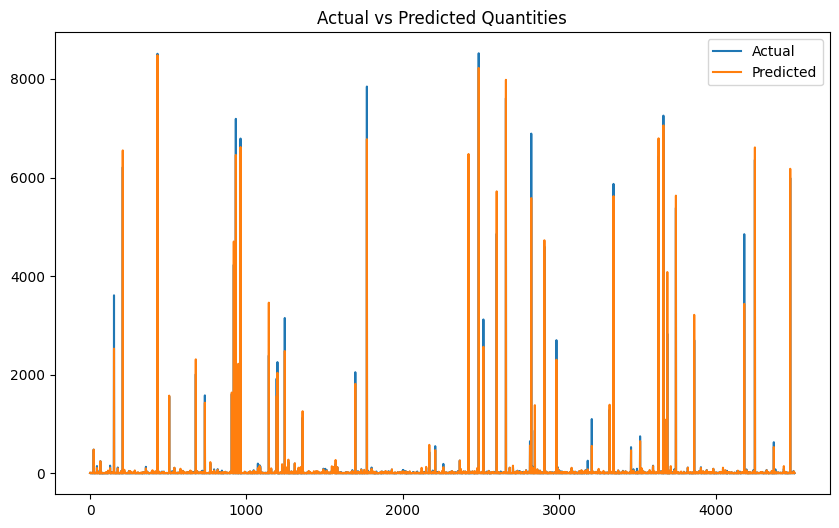

Predictions for the next month saved in '_month_stock_predictions.csv'


In [26]:
# Optional: Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Quantities')
plt.show()

print("Predictions for the next month saved in '_month_stock_predictions.csv'")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import joblib

# Load the dataset
data = pd.read_csv("sales_data.csv")  # Replace with your dataset file
data['date'] = pd.to_datetime(data[['year', 'month', 'date']])
data = data.sort_values('date')

# Aggregate daily data to monthly for consistency
monthly_data = data.groupby(['shop_name', 'item', pd.Grouper(key='date', freq='M')]) \
                   .agg({'quantity': 'sum', 'total': 'sum', 'profit': 'sum'}).reset_index()

# Feature engineering: Decompose the time series
def decompose_series(data, freq):
    decomposition = sm.tsa.seasonal_decompose(data, period=freq, model='additive', extrapolate_trend='freq')
    return decomposition.trend, decomposition.seasonal, decomposition.resid

# Apply decomposition per item and shop
monthly_data['trend'], monthly_data['seasonal'], monthly_data['residual'] = zip(*monthly_data.groupby(['shop_name', 'item'])['quantity'].apply(
    lambda x: decompose_series(x, freq=12) if len(x) >= 12 else (np.nan, np.nan, np.nan)
))

# Fill missing trends for short data
monthly_data['trend'].fillna(method='bfill', inplace=True)
monthly_data['trend'].fillna(method='ffill', inplace=True)

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(monthly_data[['shop_name', 'item']])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(['shop_name', 'item']))

# Merge encoded features back
monthly_data = pd.concat([monthly_data.reset_index(drop=True), encoded_df], axis=1)

# Add month and year as features
monthly_data['month'] = monthly_data['date'].dt.month
monthly_data['year'] = monthly_data['date'].dt.year

# Define features and target
X = monthly_data.drop(columns=['date', 'quantity', 'total', 'profit'])
y = monthly_data['quantity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# Save the model and preprocessing objects
joblib.dump(xgb_model, 'xgb_stock_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

# Multi-month prediction
def predict_future(months_to_predict):
    last_data = monthly_data.tail(1)  # Get the latest data
    predictions = []
    for i in range(months_to_predict):
        # Add month and year incrementally
        last_data['month'] += 1
        if last_data['month'].iloc[0] > 12:
            last_data['month'] = 1
            last_data['year'] += 1
        # Encode and scale new data
        encoded = encoder.transform(last_data[['shop_name', 'item']])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['shop_name', 'item']))
        new_data = pd.concat([last_data.reset_index(drop=True).drop(columns=encoder.get_feature_names_out(['shop_name', 'item'])), encoded_df], axis=1)
        scaled_data = scaler.transform(new_data)
        # Predict
        predicted_quantity = xgb_model.predict(scaled_data)
        predictions.append({'predicted_month': f"{last_data['month'].iloc[0]}-{last_data['year'].iloc[0]}",
                            'predicted_quantity': predicted_quantity[0],
                            'shop_name': last_data['shop_name'].iloc[0],
                            'item': last_data['item'].iloc[0]})
    return pd.DataFrame(predictions)

# Predict for the next 6 months
future_predictions = predict_future(6)
future_predictions.to_csv("multi_month_stock_predictions.csv", index=False)
print("Future predictions saved to 'multi_month_stock_predictions.csv'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import joblib

In [ ]:
df = pd.read_csv("/content/SBMMerge.csv",encoding='latin1')
df.head()

,Year,Month,ShopName,Item,Quantity,Total,Wholesale,Profit
0,2022,October,Gampaha,4rever 5 min clean -up,1,Rs. 570.00,Rs. 456.75,Rs. 113.25
1,2022,October,Gampaha,4rever black head remove,10,"Rs. 1,360.00","Rs. 1,087.50",Rs. 272.50
2,2022,October,Gampaha,4rever body wash,1,Rs. 440.00,Rs. 471.25,-Rs. 31.25
3,2022,October,Gampaha,4rever day cream,1,Rs. 630.00,Rs. 525.00,Rs. 105.00
4,2022,October,Gampaha,4rever eye cream,1,Rs. 620.00,Rs. 493.00,Rs. 127.00


In [ ]:
# Create Date column with first day of each month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# Optional: Add random days within each month (uncomment to use)
# df['Date'] = df['Date'] + pd.to_timedelta(np.random.randint(0, 28, len(df)), unit='D')

df.tail()

,Year,Month,ShopName,Item,Quantity,Total,Wholesale,Profit,Date
33962,2024,October,Gampaha,xhc coconut conditioner,1,"Rs. 1,800.00","Rs. 1,350.00",Rs. 450.00,2024-10-01
33963,2024,October,Gampaha,xhc coconut shampo,1,"Rs. 1,500.00","Rs. 1,100.00",Rs. 400.00,2024-10-01
33964,2024,October,Gampaha,YC face wash,3,"Rs. 2,850.00","Rs. 1,440.00","Rs. 1,410.00",2024-10-01
33965,2024,October,Gampaha,yc gold face wash,1,Rs. 950.00,Rs. 480.00,Rs. 470.00,2024-10-01
33966,2024,October,Gampaha,yellow comb,3,Rs. 240.00,Rs. 120.00,Rs. 120.00,2024-10-01


In [ ]:
# Drop unnecessary columns
df = df.drop(['Year', 'Month'], axis=1)
df.head()


,ShopName,Item,Quantity,Total,Wholesale,Profit,Date
0,Gampaha,4rever 5 min clean -up,1,Rs. 570.00,Rs. 456.75,Rs. 113.25,2022-10-01
1,Gampaha,4rever black head remove,10,"Rs. 1,360.00","Rs. 1,087.50",Rs. 272.50,2022-10-01
2,Gampaha,4rever body wash,1,Rs. 440.00,Rs. 471.25,-Rs. 31.25,2022-10-01
3,Gampaha,4rever day cream,1,Rs. 630.00,Rs. 525.00,Rs. 105.00,2022-10-01
4,Gampaha,4rever eye cream,1,Rs. 620.00,Rs. 493.00,Rs. 127.00,2022-10-01


In [ ]:
columns_to_clean = ['Total', 'Wholesale', 'Profit']  # Replace with your column names

for col in columns_to_clean:
   df[col] = (
       df[col]
       .astype(str)  # Ensure the column is treated as strings for replacement
       .str.replace('Rs.', '', regex=False)  # Remove 'Rs.' (case-sensitive)
       .str.replace(',', '', regex=False)  # Remove commas
       .str.replace('\xa0', '', regex=False)  # Remove non-breaking spaces
       .str.replace('- ', '-', regex=False)  # Fix spaces around negative sign
       .str.strip()  # Remove any leading or trailing whitespace
       .replace('-', '0')  # Replace '-' with '0' to handle missing or negative-like values
       .replace('', '0')  # Replace empty strings with '0'
       .astype(float)  # Convert the cleaned values to float
)

In [ ]:
# Aggregate daily data to monthly for consistency
monthly_data = df.groupby(['ShopName', 'Item', pd.Grouper(key='Date', freq='ME')]) \
                   .agg({'Quantity': 'sum', 'Total': 'sum', 'Profit': 'sum'}).reset_index()

In [ ]:
# Apply decomposition safely
def safe_decompose(x, freq):
    if len(x) >= 24:  # Ensure at least two full cycles
        decomposition = sm.tsa.seasonal_decompose(x, period=freq, model='additive', extrapolate_trend='freq')
        return pd.DataFrame({
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal,
            'residual': decomposition.resid
        }).reset_index(drop=True)
    else:
        # Return NaN-filled DataFrame for insufficient data
        return pd.DataFrame({
            'trend': [np.nan] * len(x),
            'seasonal': [np.nan] * len(x),
            'residual': [np.nan] * len(x)
        }).reset_index(drop=True)

# Decompose each group and merge the results
decomposed_list = []
for (shop, item), group in monthly_data.groupby(['ShopName', 'Item']):
    decomposed = safe_decompose(group['Quantity'], freq=12)
    decomposed['ShopName'] = shop
    decomposed['Item'] = item
    decomposed['Date'] = group['Date'].reset_index(drop=True)
    decomposed_list.append(decomposed)

# Concatenate all decomposed data
decomposed_df = pd.concat(decomposed_list, ignore_index=True)

# Merge decomposed data with the original DataFrame
monthly_data = pd.merge(monthly_data, decomposed_df, on=['ShopName', 'Item', 'Date'], how='left')

# Add month and year as features
monthly_data['Month'] = monthly_data['Date'].dt.month
monthly_data['Year'] = monthly_data['Date'].dt.year


# Fill NaN values in 'trend' for groups with insufficient data
monthly_data['trend'].fillna(method='bfill', inplace=True)
monthly_data['trend'].fillna(method='ffill', inplace=True)


<ipython-input-7-9460ef399f7c>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_data['trend'].fillna(method='bfill', inplace=True)
<ipython-input-7-9460ef399f7c>:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['trend'].fillna(method='bfill', inplace=True)
<ipython-input-7-9460ef399f7c>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method

In [ ]:

# Backup original ShopName and Item columns
original_categories = monthly_data[['ShopName', 'Item']].copy()

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(monthly_data[['ShopName', 'Item']])

# Create a DataFrame for encoded categories
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(['ShopName', 'Item']),
    index=monthly_data.index
)

# Drop original categorical columns and merge encoded features
monthly_data = pd.concat([monthly_data.drop(['ShopName', 'Item'], axis=1), encoded_df], axis=1)

# Reference original values later using `original_categories`


In [ ]:
# Define features and target
X = monthly_data.drop(columns=['Date', 'Quantity', 'Total', 'Profit'])
y = monthly_data['Quantity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Decode one-hot encoded ShopName and Item columns
decoded_shopname = encoded_df.filter(like='ShopName_').idxmax(axis=1).str.replace('ShopName', '')
decoded_item = encoded_df.filter(like='Item_').idxmax(axis=1).str.replace('Item', '')

# Add the decoded columns back to the DataFrame
monthly_data['ShopName'] = decoded_shopname
monthly_data['Item'] = decoded_item


In [ ]:
# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Evaluate the model
y_pred = xgb_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


RMSE: 78.22


In [ ]:
# Save the model and preprocessing objects
joblib.dump(xgb_model, 'xgb_stock_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

In [ ]:
def predict_future(months_to_predict):
    # Ensure 'Month' and 'Year' columns exist
    if 'Month' not in monthly_data.columns or 'Year' not in monthly_data.columns:
        raise ValueError("'Month' and 'Year' columns are required in monthly_data.")

    # Get the latest data
    last_data = monthly_data.tail(1).copy()
    predictions = []

    for i in range(months_to_predict):
        # Safely update Month and Year
        last_data['Month'] += 1
        if last_data['Month'].iloc[0] > 12:
            last_data['Month'] = 1
            last_data['Year'] += 1

        # Fill missing 'trend', 'seasonal', and 'residual' features
        last_data['trend'] = 0  # Replace with extrapolated or averaged value if available
        last_data['seasonal'] = 0  # Replace with extrapolated or averaged value if available
        last_data['residual'] = 0  # Replace with extrapolated or averaged value if available

        # Encode and scale new data
        encoded = encoder.transform(last_data[['ShopName', 'Item']])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['ShopName', 'Item']))

        # Merge encoded features and retain all columns used in training
        new_data = pd.concat(
            [last_data.reset_index(drop=True).drop(columns=['ShopName', 'Item']), encoded_df], axis=1
        )

        # Ensure all required columns exist
        for col in xgb_model.feature_names_in_:
            if col not in new_data.columns:
                new_data[col] = 0  # Add missing columns with default value

        # Scale the data
        scaled_data = scaler.transform(new_data[xgb_model.feature_names_in_])

        # Predict
        predicted_quantity = xgb_model.predict(scaled_data)
        predictions.append({
            'predicted_month': f"{last_data['Month'].iloc[0]}-{last_data['Year'].iloc[0]}",
            'predicted_quantity': predicted_quantity[0],
            'ShopName': last_data['ShopName'].iloc[0],
            'Item': last_data['Item'].iloc[0]
        })

    return pd.DataFrame(predictions)


In [ ]:
# Decode one-hot encoded ShopName and Item columns
decoded_shopname = encoded_df.filter(like='ShopName_').idxmax(axis=1).str.replace('ShopName', '')
decoded_item = encoded_df.filter(like='Item_').idxmax(axis=1).str.replace('Item', '')

# Add the decoded columns back to the DataFrame
monthly_data['ShopName'] = decoded_shopname
monthly_data['Item'] = decoded_item


In [ ]:
print(monthly_data.columns)


Index(['Date', 'Quantity', 'Total', 'Profit', 'trend', 'seasonal', 'residual',
       'Month', 'Year', 'ShopName_Gampaha',
       ...
       'Item_yc gold face wash', 'Item_yc gold face wash-950',
       'Item_yc lemon extract f/w -950', 'Item_yc manicure set-2000',
       'Item_yc milk extract f/w -950', 'Item_yc neem f/w',
       'Item_yc vitamin c f/w', 'Item_yellow comb', 'ShopName', 'Item'],
      dtype='object', length=4171)


In [ ]:
future_predictions = predict_future(6)
future_predictions.to_csv("multi_month_stock_predictions.csv", index=False)
print("Future predictions saved to 'multi_month_stock_predictions.csv'")


AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.

In [ ]:
# Multi-month prediction
def predict_future(months_to_predict):
    last_data = monthly_data.tail(1)  # Get the latest data
    predictions = []
    for i in range(months_to_predict):
        # Add month and year incrementally
        last_data['Month'] += 1
        if last_data['Month'].iloc[0] > 12:
            last_data['Month'] = 1
            last_data['Year'] += 1
        # Encode and scale new data
        encoded = encoder.transform(last_data[['ShopName', 'Item']])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['ShopName', 'Item']))
        new_data = pd.concat([last_data.reset_index(drop=True).drop(columns=encoder.get_feature_names_out(['ShopName', 'Item'])), encoded_df], axis=1)
        scaled_data = scaler.transform(new_data)
        # Predict
        predicted_quantity = xgb_model.predict(scaled_data)
        predictions.append({'predicted_month': f"{last_data['Month'].iloc[0]}-{last_data['Year'].iloc[0]}",
                            'predicted_quantity': predicted_quantity[0],
                            'ShopName': last_data['ShopName'].iloc[0],
                            'Item': last_data['Item'].iloc[0]})
    return pd.DataFrame(predictions)

In [ ]:
print(monthly_data.columns)

Index(['Date', 'Quantity', 'Total', 'Profit', 'trend', 'seasonal', 'residual',
       'Month', 'Year', 'ShopName_Gampaha',
       ...
       'Item_yc gold face wash', 'Item_yc gold face wash-950',
       'Item_yc lemon extract f/w -950', 'Item_yc manicure set-2000',
       'Item_yc milk extract f/w -950', 'Item_yc neem f/w',
       'Item_yc vitamin c f/w', 'Item_yellow comb', 'ShopName', 'Item'],
      dtype='object', length=4171)


In [ ]:
# Predict for the next 6 months
future_predictions = predict_future(6)
future_predictions.to_csv("multi_month_stock_predictions.csv", index=False)
print("Future predictions saved to 'multi_month_stock_predictions.csv'")


<ipython-input-19-32d173eb6735>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_data['Month'] += 1
<ipython-input-19-32d173eb6735>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_data['Month'] = 1
<ipython-input-19-32d173eb6735>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Date
- Item
- Profit
- Quantity
- ShopName
- ...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import joblib
df = pd.read_csv("/content/SBMMerge.csv",encoding='latin1')
df.head()
# Create Date column with first day of each month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# Optional: Add random days within each month (uncomment to use)
# df['Date'] = df['Date'] + pd.to_timedelta(np.random.randint(0, 28, len(df)), unit='D')

df.tail()
# Drop unnecessary columns
df = df.drop(['Year', 'Month'], axis=1)
df.head()
columns_to_clean = ['Total', 'Wholesale', 'Profit']  # Replace with your column names

for col in columns_to_clean:
   df[col] = (
       df[col]
       .astype(str)  # Ensure the column is treated as strings for replacement
       .str.replace('Rs.', '', regex=False)  # Remove 'Rs.' (case-sensitive)
       .str.replace(',', '', regex=False)  # Remove commas
       .str.replace('\xa0', '', regex=False)  # Remove non-breaking spaces
       .str.replace('- ', '-', regex=False)  # Fix spaces around negative sign
       .str.strip()  # Remove any leading or trailing whitespace
       .replace('-', '0')  # Replace '-' with '0' to handle missing or negative-like values
       .replace('', '0')  # Replace empty strings with '0'
       .astype(float)  # Convert the cleaned values to float
)
# Aggregate daily data to monthly for consistency
monthly_data = df.groupby(['ShopName', 'Item', pd.Grouper(key='Date', freq='ME')]) \
                   .agg({'Quantity': 'sum', 'Total': 'sum', 'Profit': 'sum'}).reset_index()

 # Apply decomposition safely
def safe_decompose(x, freq):
    if len(x) >= 24:  # Ensure at least two full cycles
        decomposition = sm.tsa.seasonal_decompose(x, period=freq, model='additive', extrapolate_trend='freq')
        return pd.DataFrame({
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal,
            'residual': decomposition.resid
        }).reset_index(drop=True)
    else:
        # Return NaN-filled DataFrame for insufficient data
        return pd.DataFrame({
            'trend': [np.nan] * len(x),
            'seasonal': [np.nan] * len(x),
            'residual': [np.nan] * len(x)
        }).reset_index(drop=True)

# Decompose each group and merge the results
decomposed_list = []
for (shop, item), group in monthly_data.groupby(['ShopName', 'Item']):
    decomposed = safe_decompose(group['Quantity'], freq=12)
    decomposed['ShopName'] = shop
    decomposed['Item'] = item
    decomposed['Date'] = group['Date'].reset_index(drop=True)
    decomposed_list.append(decomposed)

# Concatenate all decomposed data
decomposed_df = pd.concat(decomposed_list, ignore_index=True)

# Merge decomposed data with the original DataFrame
monthly_data = pd.merge(monthly_data, decomposed_df, on=['ShopName', 'Item', 'Date'], how='left')

# Add month and year as features
monthly_data['Month'] = monthly_data['Date'].dt.month
monthly_data['Year'] = monthly_data['Date'].dt.year


# Fill NaN values in 'trend' for groups with insufficient data
#monthly_data['trend'].fillna(method='bfill', inplace=True)
#monthly_data['trend'].fillna(method='ffill', inplace=True)

# Backup original ShopName and Item columns
original_categories = monthly_data[['ShopName', 'Item']].copy()

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(monthly_data[['ShopName', 'Item']])

# Create a DataFrame for encoded categories
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(['ShopName', 'Item']),
    index=monthly_data.index
)

# Drop original categorical columns and merge encoded features
monthly_data = pd.concat([monthly_data.drop(['ShopName', 'Item'], axis=1), encoded_df], axis=1)

# Reference original values later using `original_categories`
# Define features and target
X = monthly_data.drop(columns=['Date', 'Quantity', 'Total', 'Profit'])
y = monthly_data['Quantity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decode one-hot encoded ShopName and Item columns
decoded_shopname = encoded_df.filter(like='ShopName_').idxmax(axis=1).str.replace('ShopName_', '')
decoded_item = encoded_df.filter(like='Item_').idxmax(axis=1).str.replace('Item_', '')

# Add the decoded columns back to the DataFrame
monthly_data['ShopName'] = decoded_shopname
monthly_data['Item'] = decoded_item
# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
# Evaluate the model
y_pred = xgb_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
# Save the model and preprocessing objects
joblib.dump(xgb_model, 'xgb_stock_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')
def predict_future(months_to_predict):
    # Ensure 'Month' and 'Year' columns exist
    if 'Month' not in monthly_data.columns or 'Year' not in monthly_data.columns:
        raise ValueError("'Month' and 'Year' columns are required in monthly_data.")

    # Get the latest data
    last_data = monthly_data.tail(1).copy()
    predictions = []

    for i in range(months_to_predict):
        # Safely update Month and Year
        last_data['Month'] += 1
        if last_data['Month'].iloc[0] > 12:
            last_data['Month'] = 1
            last_data['Year'] += 1

        # Fill missing 'trend', 'seasonal', and 'residual' features
        last_data['trend'] = 0  # Replace with extrapolated or averaged value if available
        last_data['seasonal'] = 0  # Replace with extrapolated or averaged value if available
        last_data['residual'] = 0  # Replace with extrapolated or averaged value if available

        # Encode and scale new data
        encoded = encoder.transform(last_data[['ShopName', 'Item']])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['ShopName', 'Item']))

        # Merge encoded features and retain all columns used in training
        new_data = pd.concat(
            [last_data.reset_index(drop=True).drop(columns=['ShopName', 'Item']), encoded_df], axis=1
        )

        # Ensure all required columns exist
        for col in xgb_model.feature_names_in_:
            if col not in new_data.columns:
                new_data[col] = 0  # Add missing columns with default value

        # Scale the data
        scaled_data = scaler.transform(new_data[xgb_model.feature_names_in_])

        # Predict
        predicted_quantity = xgb_model.predict(scaled_data)
        predictions.append({
            'predicted_month': f"{last_data['Month'].iloc[0]}-{last_data['Year'].iloc[0]}",
            'predicted_quantity': predicted_quantity[0],
            'ShopName': last_data['ShopName'].iloc[0],
            'Item': last_data['Item'].iloc[0]
        })

    return pd.DataFrame(predictions)

# Decode one-hot encoded ShopName and Item columns
decoded_shopname = encoded_df.filter(like='ShopName_').idxmax(axis=1).str.replace('ShopName_', '')
decoded_item = encoded_df.filter(like='Item_').idxmax(axis=1).str.replace('Item_', '')

# Add the decoded columns back to the DataFrame
monthly_data['ShopName'] = decoded_shopname
monthly_data['Item'] = decoded_item

future_predictions = predict_future(6)
future_predictions.to_csv("multi_month_stock_predictions.csv", index=False)
print("Future predictions saved to 'multi_month_stock_predictions.csv'")

